In [1]:
import sys
import os
#sys.path.append("/home/phi.richter/SOFTWARE_PHD/run_RRTMG_OOP")
sys.path.append("/home/philipp/Doktorandenzeit/SOFTWARE_PHD/run_RRTMG_OOP")
import rrtmg as FLUXES
import numpy as np

In [2]:
## Profiles
z = np.loadtxt("/home/philipp/Doktorandenzeit/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/z.csv", delimiter=",")#np.loadtxt("/home/phi.richter/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/z.csv", delimiter=",")
co2 = np.loadtxt("/home/philipp/Doktorandenzeit/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/co2.csv", delimiter=",")#np.loadtxt("/home/phi.richter/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/co2.csv", delimiter=",")
o3 = np.loadtxt("/home/philipp/Doktorandenzeit/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/o3.csv", delimiter=",")#np.loadtxt("/home/phi.richter/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/o3.csv", delimiter=",")
ch4 = np.loadtxt("/home/philipp/Doktorandenzeit/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/ch4.csv", delimiter=",")#np.loadtxt("/home/phi.richter/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/ch4.csv", delimiter=",")
n2o = np.loadtxt("/home/philipp/Doktorandenzeit/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/n2o.csv", delimiter=",")#np.loadtxt("/home/phi.richter/SOFTWARE_PHD/Total_Cloud_Water_retrieval/retrieval/trace_gases/n2o.csv", delimiter=",")

In [3]:
import netCDF4 as nc
#with nc.Dataset("/mnt/beegfs/user/phi.richter/REMOVE/ERA5/ozone.nc", "r") as f:
with nc.Dataset("/home/philipp/Doktorandenzeit/DATA_PHD/ERA5/ozone.nc", "r") as f:
    o3 = f.variables['o3'][:]
    z_era5 = f.variables['z'][:]/9.80665*1e-3
    lat = np.argmin(np.abs(np.array(f.variables['latitude'][:])-81.95))
    lon = np.argmin(np.abs(np.array(f.variables['longitude'][:])-10.33))
print(lat, lon)

12 81


In [4]:
import scipy.interpolate
o3_f = scipy.interpolate.interp1d(np.array(z_era5[0,:,12,81]), np.array(o3[0,:,12,81]), fill_value="extrapolate")
o3 = o3_f(np.array(z))

In [5]:
path_retrievals = "/home/philipp/Doktorandenzeit/DATA_PHD/RRTMG/INPUT/INPUT_FOR_RRTMG/RRTMG_input_nomod"#"/mnt/beegfs/user/phi.richter/DATA_PHD/RRTMG/INPUT/INPUT_FOR_RRTMG/RRTMG_input_nomod"
ssp_ice = "./"
ssp_wat = "./"
files = sorted(os.listdir(path_retrievals))

In [6]:
path_rrtmg = "/home/philipp/Doktorandenzeit/SOFTWARE_PHD/run_RRTMG_OOP"#"/home/phi.richter/SOFTWARE_PHD/run_RRTMG_OOP"
model = FLUXES.RRTMG(path_rrtmg+"/rrtmg_lw_v5.00_linux_pgi", path_rrtmg+"/rrtmg_sw_v5.00_linux_pgi", \
                  [ssp_wat, ssp_ice])

in_CNET_20170606_204444_81.950648_10.539039_73.62477298934044.nc


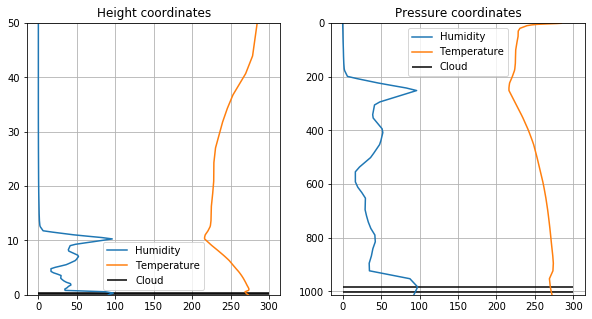

{'LWP(gm-2)': array([0.      , 4.983024]), 'IWP(gm-2)': array([0.78935552, 0.90700806]), 'rliq(um)': array([ 5.        , 11.74656987]), 'rice(um)': array([48.08694839, 47.57210986]), 'clt': array([1., 1.]), 'red_chi_2': array(None, dtype=object)}


In [7]:
epsilon = 0.99*np.ones(16)
epsilon[np.array([5,6,7])] = 0.98
spec = files[10000]
print(spec)
#atm_file = "/mnt/beegfs/user/phi.richter/ERA5_atm_interpolated/ERA5"+spec.split("in_CNET")[1].split(".nc")[0]+".csv"
model.read_cloudnet(os.path.join(path_retrievals, spec))#, pattern_fname="ERA5_%Y%m%d_%H%M%S.nc")
model.plot_atmosphere()
print(model.get_cparam())
atm = model.get_atmosphere()
model.scale('cwp', 10)
model.scale('lwp', 10)
model.scale('iwp', 10)
#model.replace_atmosphere(atm_file)
#model.plot_atmosphere()

In [8]:
o3_ppmv = 0.*np.ones(z.size)#np.ones(z.size)#28.9644 / 47.9982 * 1e6 * o3
co2 = np.zeros(z.size)
n2o = np.zeros(z.size)
ch4 = np.zeros(z.size)
tg = model.read_trace_gases(z, co2, n2o, ch4, o3_ppmv)
#model.plot_atmosphere()

In [9]:
epsilon = 0.99*np.ones(16)
atm = "H444444"#"HAAA4A4"
epsilon[np.array([7,8,9,10])] = 0.98
in_cld_rrtm = model.create_inputfile_cloud()
input_rrtm = model.create_inputfile_atm_terrestrial(cloud=0, semiss=epsilon, atm=atm)
model.run_RRTMG_terrestrial(clouds=False)
input_rrtm = model.create_inputfile_atm_terrestrial(cloud=2, semiss=epsilon, atm=atm)
model.run_RRTMG_terrestrial(clouds=True)
input_rrtm = model.create_inputfile_atm_solar(cloud=0, atm=atm, aerosols=0)
#input_aer = model.create_inputfile_aerosols_solar(level=[1], aot=[0.05], num_aer=1, iaod=0, issa=0, ipha=0, aerpar=[0.13, 1.0, 0.0], ssa=[0.780], phase=[0.7])
model.run_RRTMG_solar(clouds=False)
input_rrtm = model.create_inputfile_atm_solar(cloud=2, atm=atm, aerosols=0)
model.run_RRTMG_solar(clouds=True)

In [10]:
model.get_fluxes_terrestrial(17)['all']['DOWNWARD FLUX'].iloc[73]-model.get_fluxes_terrestrial(17)['clear']['DOWNWARD FLUX'].iloc[73]

83.33559999999997

In [11]:
print(model.get_atmosphere()['temperature'])
print(model.temp_half_levels())

[273.02114207 271.26262706 270.11023401 268.9316541  273.50721333
 274.01576151 273.30289483 272.29555618 271.32448872 270.45610534
 269.55799857 268.60636555 267.6263252  266.61780177 265.48141857
 264.34503536 263.07309066 261.78109903 260.38116281 258.82146418
 257.26176555 255.77844667 254.3196742  252.86090173 251.38004896
 249.8969391  248.41382924 246.58003432 244.66316142 242.74628853
 240.76045092 238.68073366 236.60101639 234.52129963 232.38616193
 230.22657275 228.06698569 225.90739863 223.89145466 221.99506996
 220.09868527 218.20230058 216.30591589 216.27796357 216.62059636
 217.10810316 218.33715197 219.56620079 220.74953318 221.64851128
 222.54748938 223.44646749 223.89377198 223.90686419 223.93304617
 223.95922978 223.9854134  224.01159701 224.03777899 224.0639626
 224.09014622 224.60675643 224.82030058 225.09220462 226.83239045
 228.14814071 228.37096939 230.51436901 239.71003088 245.93066469
 253.17790202 269.70170926 278.71698602 284.41901261]
[272.1509825  270.69150

In [12]:
epsilon = 0.99*np.ones(16)
atm = "H444444"#"HAAA4A4"
epsilon[np.array([7,8,9,10])] = 0.98
in_cld_rrtm = model.create_inputfile_cloud()
input_rrtm = model.create_inputfile_atm_terrestrial(cloud=0, semiss=epsilon, atm=atm)
model.run_RRTMG_terrestrial(clouds=False)
input_rrtm = model.create_inputfile_atm_terrestrial(cloud=2, semiss=epsilon, atm=atm)
model.run_RRTMG_terrestrial(clouds=True)
input_rrtm = model.create_inputfile_atm_solar(cloud=0, atm=atm, aerosols=0)
#input_aer = model.create_inputfile_aerosols_solar(level=[1], aot=[0.05], num_aer=1, iaod=0, issa=0, ipha=0, aerpar=[0.13, 1.0, 0.0], ssa=[0.780], phase=[0.7])
model.run_RRTMG_solar(clouds=False)
input_rrtm = model.create_inputfile_atm_solar(cloud=2, atm=atm, aerosols=0)
model.run_RRTMG_solar(clouds=True)

In [13]:
model.get_fluxes_terrestrial(17)['all']['DOWNWARD FLUX'].iloc[73]-model.get_fluxes_terrestrial(17)['clear']['DOWNWARD FLUX'].iloc[73]

81.99510000000001